# Example #3 : Similarity search using aperturedb.
The following notebook explains how to use aperturedb's built in similarity search feature.

## Prerequisites:
 - Access to aperturedb instance.
 - aperturedb-python installed.
 - pytorch installed
 - Setup the kaggle api (Refer to [Readme](https://github.com/aperture-data/aperturedb-python/blob/develop/examples/README.md))
 - celeba dataset from pytorch datasets.


In [1]:
#Define some common variables.
from ExamplesHelper import ExamplesHelper

helper = ExamplesHelper()
search_set_name = "similar_celebreties"

## Steps

### DescriptorSets and Descriptors

DescriptorSets are a Sets of Feature Vectors, which are extracted using the same algorthm. These are essential building blocks to ensure that the search we intend to perform is 'apples' to 'apples'.

The term 'Descriptors' and 'Feature Vectors' would be used interchangeably in the context of the API.

For more details on these two aperturedb conccepts, refer to [DescriptorSets](https://docs.aperturedata.io/commands/AddDescriptorSet.html) and [Descriptors](https://docs.aperturedata.io/commands/AddDescriptor.html)

In [20]:
from aperturedb import Utils


con = helper.create_connector()
utils = Utils.Utils(con)
utils.remove_descriptorset(search_set_name)
utils.add_descriptorset(search_set_name, 512, 
    metric=["L2"], engine="FaissFlat")

errors = 0

### Loading kaggle dataset into aperturedb.
This step uses a dataset celebA, which is available on kaggle, and ingests it into apertureDB.
Also, similar to the generator function in [Example #1](https://python.docs.aperturedata.io/examples/loaders.html#loading-pytorch-dataset-into-aperturedb), we define something similar for this dataset.

Also, specifically for the purpose of faciliatating similarity search, we generate Feature Vectors for all the images of this dataset. 
While ingesting the dataset, the corresponding Featue Vectors would be added with the confines of the DescriptorSet we created previously.

In [2]:
from facenet_pytorch import MTCNN, InceptionResnetV1
from PIL import Image
import torch

# If required, create a face detection pipeline using MTCNN:
mtcnn = MTCNN(image_size=96, margin=0)

# Create an inception resnet (in eval mode):
resnet = InceptionResnetV1(pretrained='vggface2').eval()


def generate_embedding(img):
    global errors
    # Get cropped and prewhitened image tensor
    img_cropped = mtcnn(img)
    if img_cropped is not None:
        # Calculate embedding (unsqueeze to add batch dimension)
        img_embedding = resnet(img_cropped.unsqueeze(0))
    else:
        img_embedding = torch.FloatTensor(1, 512)
        errors += 1


    return img_embedding

/home/ubuntu/Projects/aperturedb-python/env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
from aperturedb.KaggleDataset import KaggleDataset
from aperturedb import ParallelQuery
from PIL import Image
import io
import os
import pandas as pd

dataset_ref="jessicali9530/celeba-dataset"


# kaggle datasets do not conform to a enforcing structure.
# This function is needed in addition to the item conversion (ref Example 1) to 
# have an iterable withe all the inormation needed per item.
def get_collection_from_multiple_index(root):
    attr_index = pd.read_csv(
        os.path.join(root, "list_attr_celeba.csv"))
    bbox_index = pd.read_csv(
        os.path.join(root, "list_bbox_celeba.csv"))
    landmarks_index = pd.read_csv(os.path.join(
        root, "list_landmarks_align_celeba.csv"))
    partition_index = pd.read_csv(
        os.path.join(root, "list_eval_partition.csv"))
    
    #For sake of running the demo in a reasonable time, let's ingest first 1000 images.
    rows = attr_index.combine_first(bbox_index).combine_first(landmarks_index).combine_first(partition_index)[:10000]
    print(f"Discovered {len(rows)} items in the original dataset.")
    return rows

# Create a kaggle dataset.
dataset = KaggleDataset(
    dataset_ref=dataset_ref,
    indexer=get_collection_from_multiple_index
)
print(len(dataset))

#define a function to convert an item from celebA to queries for 
#aperturedb.
def process_item(dataset_ref, workdir, columns, row):
    p = row
    t = [
        {
            "AddImage": {
                "_ref": 1,
                "properties": {
                    c: p[c] for c in columns
                },
            }
        }, {
            "AddBoundingBox": {
                "_ref": 2,
                "image": 1,
                "rectangle": {
                    "x": p["x_1"],
                    "y": p["y_1"],
                    "width": p["width"],
                    "height": p["height"]
                }
            }
        }, {
            "AddDescriptor": {
                "set": search_set_name,
                "connect": {
                    "ref": 1
                }
            }
        }
    ]
    t[0]["AddImage"]["properties"]["keypoints"] = f"10 {p['lefteye_x']} {p['lefteye_y']} {p['righteye_x']} {p['righteye_y']} {p['nose_x']} {p['nose_y']} {p['leftmouth_x']} {p['leftmouth_y']} {p['rightmouth_x']} {p['rightmouth_y']}"
    image_file_name = os.path.join(
        workdir,
        'img_align_celeba/img_align_celeba',
        p["image_id"])
    blob = open(image_file_name, "rb").read()
    embedding = generate_embedding(Image.open(image_file_name))
    serialized = embedding.cpu().detach().numpy().tobytes()
    # print(len(serialized))
    return t, [blob, serialized]

# Ingest from the dataset created previously using a ParallellQuery.
loader = ParallelQuery.ParallelQuery(helper.create_connector())
loader.query(
    generator = list(map(lambda item: process_item(
        dataset_ref=dataset_ref,
        workdir = os.path.join("kaggleds", dataset_ref),
        columns = item.keys(),
        row = item
    ), dataset)),
    batchsize = 1,
    numthreads = 1,
    stats = True
)


### Inspecting a sample of the data that has been ingested into apertureDB


/home/ubuntu/Projects/aperturedb-python/env/lib/python3.8/site-packages/aperturedb-0.1.7-py3.8.egg/aperturedb/Utils.py:403: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/home/ubuntu/Projects/aperturedb-python/env/lib/python3.8/site-packages/aperturedb-0.1.7-py3.8.egg/aperturedb/Utils.py:403: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/home/ubuntu/Projects/aperturedb-python/env/lib/python3.8/site-packages/aperturedb-0.1.7-py3.8.egg/aperturedb/Utils.py:403: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/home/ubuntu/Projects/aperturedb-python/env/lib/python3.8/site-packages/aperturedb-0.1.7-py3.8.egg/aperturedb/Utils.py:403: SyntaxWarning: "is not" with a literal. Did you mean "!="?


Images in the DB = 10000


,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,...,nose_x,nose_y,partition,righteye_x,righteye_y,rightmouth_x,rightmouth_y,width,x_1,y_1
0,-1,1,1,-1,-1,-1,-1,-1,-1,1,...,85,137,0,107,111,111,153,177,70,67
1,-1,-1,1,-1,-1,-1,1,-1,-1,1,...,90,133,0,108,111,104,152,195,92,59
2,-1,-1,1,-1,-1,1,-1,-1,-1,1,...,78,133,0,108,112,104,152,208,111,89
3,-1,-1,1,-1,-1,1,-1,-1,-1,-1,...,80,138,0,108,112,108,151,99,42,54
4,-1,-1,1,-1,-1,-1,-1,-1,1,-1,...,89,126,0,107,111,103,153,140,127,45


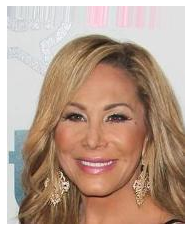

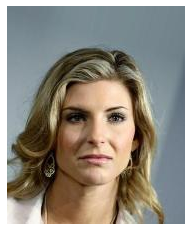

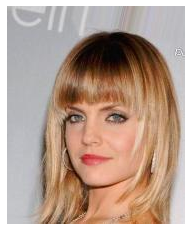

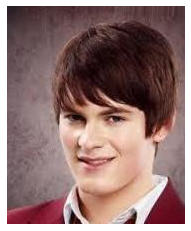

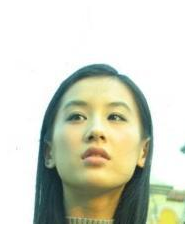

In [4]:
from aperturedb import Images, Connector, Utils
import pandas as pd

con = helper.create_connector()
utils = Utils.Utils(con)

print(f"Images in the DB = {utils.count_images()}")

images = Images.Images(con)
constraints = Images.Constraints()
constraints.equal("dataset_name", "jessicali9530/celeba-dataset")

images.search(limit=5)

images.display(show_bboxes=False)

pd.json_normalize(images.get_properties(images.get_props_names()).values())

### Finding an image which is similar to the images ingested.

Let's pick some publicly available image, and generate it's feacture vector using same algorithm as used for ingestion.
Our database consists of around ~10000 images of people worldwide, which is not that big.
But if this is completely ingested, we should see more relavant matching images.

*Fun experiment* : Upload your photo and see which celebrety you resemble


/home/ubuntu/Projects/aperturedb-python/env/lib/python3.8/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


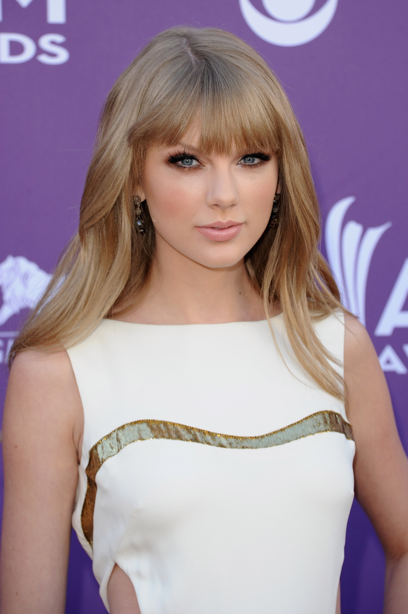

[{'FindDescriptor': {'entities': [{'_distance': 0.5701582431793213, '_id': 8997, '_name': 'similar_celebreties', '_uniqueid': 26995}, {'_distance': 0.6319935321807861, '_id': 5897, '_name': 'similar_celebreties', '_uniqueid': 17695}, {'_distance': 0.7393477559089661, '_id': 3159, '_name': 'similar_celebreties', '_uniqueid': 9481}, {'_distance': 0.7498405575752258, '_id': 2273, '_name': 'similar_celebreties', '_uniqueid': 6823}, {'_distance': 0.7879961133003235, '_id': 5884, '_name': 'similar_celebreties', '_uniqueid': 17656}], 'returned': 5, 'status': 0}}, {'FindImage': {'blobs_start': 0, 'entities': [{'_uniqueid': 26993}, {'_uniqueid': 17693}, {'_uniqueid': 9479}, {'_uniqueid': 6821}, {'_uniqueid': 17654}], 'returned': 5, 'status': 0}}]
26993
17693
9479
6821
17654


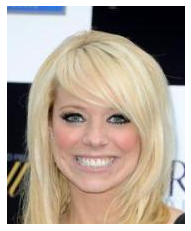

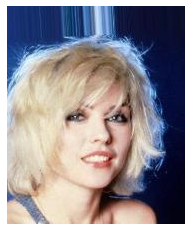

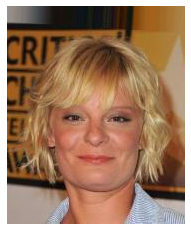

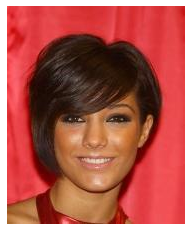

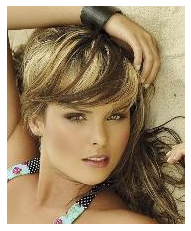

In [7]:
from IPython.display import display
from PIL import Image
#This query finds descriptors that are closest distance to the input sample.
# Further it finds images connected to those descriptors and displays them.
q = [{
    "FindDescriptor": {
        "set": search_set_name,
        "k_neighbors": 5,
        "distances": True,
        "blobs": False,
        "ids": True,
        "results":{
            "all_properties": True
        },
        "_ref": 1
    }
}, {
    "FindImage": {
        "is_connected_to": {
            "ref": 1,
        },
        "results": {
            "list": ["_uniqueid"]
        }
    }
}]

image_name = "taylor-swift.jpg" # or try with taylor-swift.jpg/bruce-lee.jpg
embedding = generate_embedding(Image.open(image_name).convert('RGB'))
r, b = con.query(q, [embedding.cpu().detach().numpy().tobytes()])
pilImage = Image.open(image_name)
display(pilImage.resize( (int(pilImage.width * 0.3), int(pilImage.height * 0.3)) ))
print(r)
data = pd.json_normalize(r[1]['FindImage']['entities'])


imgs = Images.Images(con)
for d in data['_uniqueid']:
    print(d)
    imgs.images_ids.append(d)

imgs.display()
